In [4]:
import numpy as np
import netCDF4 as nc
import csv 
import matplotlib.pyplot as plt 
import matplotlib.dates as pltd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
from matplotlib.collections import PolyCollection
import pandas
import xarray as xr
import xesmf as xe

In [5]:
file_dir = '/work/Alison.Novara/'

# For now, this is a dictionary containg the file names. 
#     We can add more to it to include details for plots and analyses
organism_dict = {'A_irradians_range',
                 'L_helicina_range',
                 'P_astreoides_range'}


In [6]:
# Here I have chosen to just look at the irradians as a test case for the code. You can sub in any of the files
csv_fil = file_dir + 'A_irradians_range'

location_df = pandas.read_csv(csv_fil,encoding= 'unicode_escape')
# show what's in dataframe df:
location_df

,latitude,longitude
NaN,9.25,80.25
NaN,9.25,82.25
NaN,9.75,-75.75
NaN,10.25,-83.25
NaN,11.25,-70.25
...,...,...
NaN,42.25,-70.75
NaN,42.25,-71.25
NaN,42.75,-70.75
NaN,43.75,-70.25


In [7]:
# Read in the carbonate chemistry files - we're starting with the historical period
ksp_fid = nc.Dataset('co3satarag_1975-2014_his.nc')
co3_fid = nc.Dataset('co3_1975-2014_his.nc')

# extract the variable from the netcdf file. 
co3sat = ksp_fid.variables['co3satarag'][:].squeeze()
co3 = co3_fid.variables['co3'][:].squeeze()

# just using the surface
surf_co3sat = co3sat[:,0,:,:]
surf_co3 = co3[:,0,:,:]

# calculating aragonite saturation state:
#    co3/co3sat = arag saturation state 
surf_arag_sat = np.mean(surf_co3/surf_co3sat,axis=0)
surf_arag_sat.fill_value = 0

# geographic information
lat = ksp_fid.variables['lat'][:]
lon = ksp_fid.variables['lon'][:]

# Corner lat/lon for pcolormesh plots
clat = np.append(ksp_fid.variables['lat_bnds'][:,0],ksp_fid.variables['lat_bnds'][-1,-1])
clon = np.append(ksp_fid.variables['lon_bnds'][:,0],ksp_fid.variables['lon_bnds'][-1,-1])

## Making the xarray Datasets for using with the xesmf regridder. 

In [8]:
# extracting the lon/lat variables from the dataframe
# defining the xarray Dataset for the organism locations
organism_locs = xr.Dataset()
organism_locs["lon"] = xr.DataArray(data=location_df.longitude, dims=("locations"))
organism_locs["lat"] = xr.DataArray(data=location_df.latitude, dims=("locations"))


# defining the model grid as an xarray Dataset
model_grid = xr.Dataset()

# adding in the information for the geographic coordinates
model_grid["lon"] = xr.DataArray(data=lon, dims=("lon"))
model_grid["lat"] = xr.DataArray(data=lat, dims=("lat"))


# Creating the xesmf regridder o
regridder = xe.Regridder(model_grid, organism_locs, 'nearest_s2d', locstream_out=True, periodic=True)

## Getting organism values for aragonite saturation state

In [9]:
organism_surf_arag = regridder(surf_arag_sat).squeeze()

## Plot distribution of historical mean-state surface aragonite saturation state for this organism


(array([ 7.,  0.,  0.,  0.,  3., 16., 11., 18., 46.,  5.]),
 array([0.        , 0.46645625, 0.9329125 , 1.39936874, 1.86582499,
        2.33228124, 2.79873749, 3.26519374, 3.73164998, 4.19810623,
        4.66456248]),
 <BarContainer object of 10 artists>)

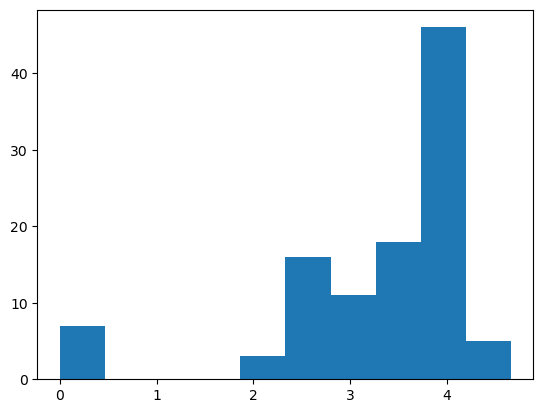

In [10]:
# Simple histogram
plt.hist(organism_surf_arag)

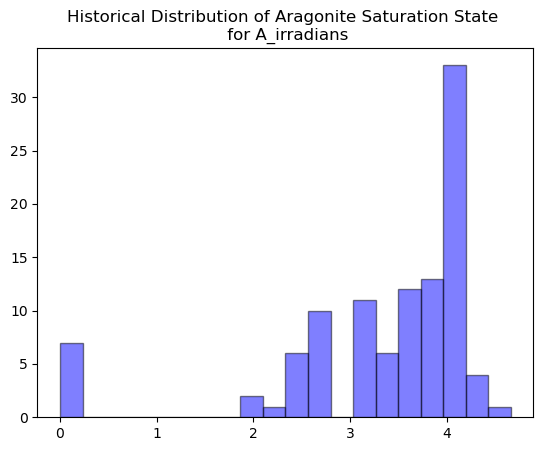

In [11]:
# fancier histogram plot
num_bins = 20
n, bins, patches = plt.hist(organism_surf_arag, num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5)
title = plt.title('Historical Distribution of Aragonite Saturation State \n for A_irradians')

In [12]:
# Now we can add the future model output for comparison. Notice that I have added "fut" to all
# of the variable names to distinguish them from the historical values we read in earlier

# Read in the carbonate chemistry files - we're starting with the historical period
ksp_fut_fid = nc.Dataset('co3satarag_2061-2100_ssp585.nc')
co3_fut_fid = nc.Dataset('co3_2061-2100_ssp585.nc')

# extract the variable from the netcdf file. 
co3sat_fut = ksp_fut_fid.variables['co3satarag'][:].squeeze()
co3_fut = co3_fut_fid.variables['co3'][:].squeeze()

# just using the surface
surf_co3sat_fut = co3sat_fut[:,0,:,:]
surf_co3_fut = co3_fut[:,0,:,:]

# calculating aragonite saturation state:
#    co3/co3sat = arag saturation state 
surf_arag_sat_fut = np.mean(surf_co3_fut/surf_co3sat_fut,axis=0)
surf_arag_sat_fut.fill_value = 0

In [13]:
# we can use the same regridder tool we made earlier since the lat/lon locations "should" not have changed
organism_surf_arag_fut = regridder(surf_arag_sat_fut).squeeze()

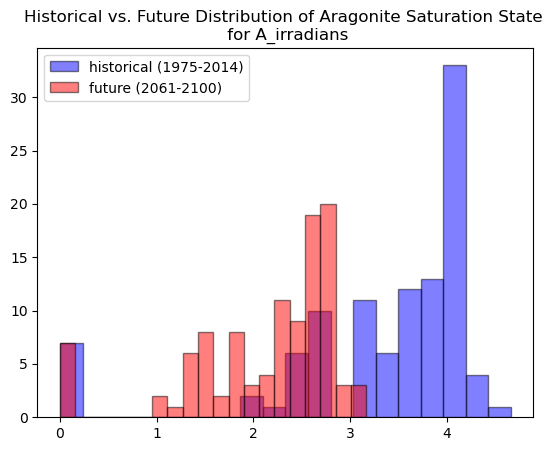

In [14]:
# comparison of future vs. historical
num_bins = 20
n, bins, patches = plt.hist(organism_surf_arag, num_bins, facecolor='blue', edgecolor = 'black', alpha=0.5, label = 'historical (1975-2014)')
n, bins, patches = plt.hist(organism_surf_arag_fut, num_bins, facecolor='red', edgecolor = 'black', alpha=0.5, label = 'future (2061-2100)')
title = plt.title('Historical vs. Future Distribution of Aragonite Saturation State \n for A_irradians')
plt.legend()

In [15]:
# Try this out, experimenting with out you would want the plots to look

In [77]:
# Here is a code below showing how I currently generate figures when I want to perform 
# a common step ( such as calculations or plots ) over and over again

In [18]:
# I start with my dictionaries with all the details I want 
file_dir = '/work/Alison.Novara/'

# For now, this is a dictionary containg the file names. 
#     We can add more to it to include details for plots and analyses
organism_dict = {'scallop':{'file_name':'A_irradians', 'plot_title':'$\it{Argopecten}$ $\it{irradians}$', 'his_color':'darkblue'},
                 'pteropod':{'file_name':'L_helicina','plot_title':'$\it{Limacina}$ $\it{helicina}$','his_color':'mediumpurple'},
                 'coral':{'file_name':'P_astreoides','plot_title':'$\it{Porites}$ $\it{astreoides}$','his_color':'orange'}}

time_periods = ['1975-2014_his','2061-2100_ssp585']


In [19]:
import copy

# Here I am itterating over the time periods because it's the same process for reading them in
# I just need to need to be careful about assigning them the correct variable name at the end

for time_per in time_periods:
    
    # create the file name string
    co3satarag_ncfile = 'co3satarag_' + time_per + '.nc'
    co3_ncfile = 'co3_' + time_per + '.nc'
    
    # Read in the carbonate chemistry files - we're starting with the historical period
    ksp_fid = nc.Dataset(co3satarag_ncfile)
    co3_fid = nc.Dataset(co3_ncfile)

    # extract the variable from the netcdf file. 
    co3sat = ksp_fid.variables['co3satarag'][:].squeeze()
    co3 = co3_fid.variables['co3'][:].squeeze()

    # just using the surface
    surf_co3sats = co3sat[:,0,:,:]
    surf_co3 = co3[:,0,:,:]

    # calculating aragonite saturation state:
    #    co3/co3sat = arag saturation state 
    surf_arag_sat = np.mean(surf_co3/surf_co3sat,axis=0)
    surf_arag_sat.fill_value = 0
    
    if time_per == '1975-2014_his':
        # save the historical value for saturation state 
        surf_arag_sat_his = copy.deepcopy(surf_arag_sat)
        
        # geographic information
        lat = ksp_fid.variables['lat'][:]
        lon = ksp_fid.variables['lon'][:]

        # Corner lat/lon for pcolormesh plots
        clat = np.append(ksp_fid.variables['lat_bnds'][:,0],ksp_fid.variables['lat_bnds'][-1,-1])
        clon = np.append(ksp_fid.variables['lon_bnds'][:,0],ksp_fid.variables['lon_bnds'][-1,-1])
        
        # generate the xarray Dataset for the model grid
        # defining the model grid as an xarray Dataset
        model_grid = xr.Dataset()

        # adding in the information for the geographic coordinates
        model_grid["lon"] = xr.DataArray(data=lon, dims=("lon"))
        model_grid["lat"] = xr.DataArray(data=lat, dims=("lat"))

    else:
        # save the historical value for saturation state 
        surf_arag_sat_fut = copy.deepcopy(surf_arag_sat)


In [1]:
def plot_arag_hist():
    plt.figure()
    n, bins, patches = plt.hist(organism_surf_arag_his, num_bins, facecolor=organism_dict[critter]['his_color'], edgecolor = 'black', alpha=0.75, label = 'historical (1975-2014)')
    n, bins, patches = plt.hist(organism_surf_arag_fut, num_bins, facecolor='red', edgecolor = 'black', alpha=0.6, label = 'future (2061-2100)')
    title = plt.title(('Historical and Projected Distributions of Aragonite Saturation State \n for ' + organism_dict[critter]['plot_title']), fontweight='bold')
    plt.xlabel('Aragonite Saturation State')
    plt.ylabel('# of locations')
    plt.legend()
    plt.savefig(critter)

In [2]:
# I want to make a futre vs. historical plot for all three organisms

# I iterate over all of the organisms in the dictionary
#colors = ['darkblue', 'mediumpurple', 'orange'] 
for i, critter in enumerate(organism_dict):
    print(critter)
   
    # construct string for file name
    csv_fil = file_dir + organism_dict[critter]['file_name'] + '_range'
    #print(csv_fil)

    # create the pandas dataframe
    if critter == 'scallop':
        location_df = pandas.read_csv(csv_fil)
    else: 
        location_df = pandas.read_csv(csv_fil,delim_whitespace=True)
    # show what's in dataframe df:
    #print(location_df)
    
    # extracting the lon/lat variables from the dataframe
    # defining the xarray Dataset for the organism locations
    organism_locs = xr.Dataset()
    organism_locs["lon"] = xr.DataArray(data=location_df.longitude, dims=("locations"))
    organism_locs["lat"] = xr.DataArray(data=location_df.latitude, dims=("locations"))
    
    # Creating the xesmf regridder which will be different for each organism
    regridder = xe.Regridder(model_grid, organism_locs, 'nearest_s2d', locstream_out=True, periodic=True)
    
    organism_surf_arag_his = regridder(surf_arag_sat_his).squeeze()
    organism_surf_arag_fut = regridder(surf_arag_sat_fut).squeeze()
   
    # I've made a function for generating the individual figures because it's the same for every 
    # organism and I wanted to separate it from the rest of the code because it felt "cleaner"
 
    plot_arag_hist()

NameError: name 'organism_dict' is not defined